<a href="https://colab.research.google.com/github/Sudhandar/EfficientNet-Attention-in-a-Siamese-Network/blob/main/EfficientNet_with_attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import init
import os 
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchsummary import summary
from statistics import mode
from math import ceil
import torch.nn.functional as F
import seaborn as sns
import random
import time
import math
from collections import Counter
import pandas as pd
from sklearn.manifold import TSNE
import torch.optim as optim

In [ ]:
!gdown --id 1nAm_DOaZ4YWFlEW49RZplJX-678mgsy1

In [ ]:
!unzip Colab.zip

## EfficientNetB0 Baseline Model

In [ ]:
epochs = 25
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 8
img_size = 224
n_classes = 4
version = "b0"
torch.manual_seed(35)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device Name: {}".format(device))

Device Name: cuda


In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (img_size,img_size)),
    transforms.Normalize([0.5094, 0.5094, 0.5094], [0.2355, 0.2355, 0.2355]),
    transforms.RandomHorizontalFlip(),
])

dataset = ImageFolder(root='Colab', transform=transformer)
print(dataset.class_to_idx)
dataloader = torch.utils.data.DataLoader(
  dataset, 
  # batch size is whole datset
  batch_size= batch_size, 
  shuffle=False, 
  num_workers=2)

{'Covid': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [ ]:
nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(dataloader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

In [ ]:
print(dict(Counter(dataset.targets)))

{0: 3616, 1: 6012, 2: 10192, 3: 1345}


In [ ]:
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.15, stratify=dataset.targets)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [ ]:
print(len(train_dataset), len(test_dataset))

17990 3175


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True)

In [ ]:
def accuracy(y_pred,y_true):
    y_pred = nn.functional.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
class Trainer():
    def __init__(self, criterion, optimizer, schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self, model, trainloader):
        
        train_acc = 0.0
        train_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            # nn.utils.clip_grad_value_(model.parameters(), 1)
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
            
        return train_acc/len(trainloader), train_loss/len(trainloader)

    
    def valid_batch_loop(self, model, validloader):
        
        valid_acc = 0.0
        valid_loss = 0.0
        
        for images, labels in tqdm(validloader):

            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            valid_acc += accuracy(logits, labels)
            valid_loss += loss.item()
        
        return valid_acc/len(validloader), valid_loss / len(validloader)

    def valid_batch_loop_test(self, model, validloader):

        total = 0
        correct = 0
        final_prediction = []
        final_labels = []

        for images, labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)

            y_pred = nn.functional.softmax(logits,dim = 1)
            _, predicted = torch.max(y_pred, dim=1)

            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
            final_labels.append(labels.cpu().detach().numpy())
            final_prediction.append(predicted.cpu().detach().numpy())
        final_labels = np.concatenate(final_labels)
        final_prediction = np.concatenate(final_prediction)
        print("Test Accuracy: {:.2f} %".format((correct/total)*100))
        print("Classification Report:")
        print(classification_report(final_labels, final_prediction, target_names= ["Covid","Other Lung Infection","Normal","Viral Pneumonia"]))
        print("F1 Score: {:.5f}".format(f1_score(final_labels, final_prediction, average = "weighted")))

    def test(self, model, validloader):

        model.eval()
        self.valid_batch_loop_test(model, validloader)


    def fit(self, model, trainloader, validloader, epochs):
        
        model = model.to(device)
        valid_min_loss = np.Inf
        train_loss_list = []
        validation_loss_list = []

        for i in range(epochs):
            
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            # self.schedular.step(avg_train_loss)
            train_loss_list.append([i+1, avg_train_loss])
            
            model.eval()
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            validation_loss_list.append([i+1, avg_valid_loss])

            if avg_valid_loss <= valid_min_loss:
                print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), "model.pt")
                valid_min_loss = avg_valid_loss
                
            print("Epoch: {} Train Loss: {} Train Acc: {}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch: {} Valid Loss: {} Valid Acc: {}".format(i+1, avg_valid_loss, avg_valid_acc))
        return train_loss_list, validation_loss_list

In [ ]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [ ]:
model = EfficientNet(version, n_classes)
model.to(device)

In [ ]:
summary(model, (3,img_size, img_size))

In [ ]:
def plot_loss_graphs(training_loss_list,validation_loss_list, title):
  df_stats = pd.DataFrame(training_loss_list, columns = ['epoch','training_loss'])
  df_stats_val = pd.DataFrame(validation_loss_list, columns = ['epoch','validation_loss'])
  df_stats = pd.merge(df_stats, df_stats_val, on = 'epoch', how = 'inner')

  sns.set(style='darkgrid')
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,4)
  plt.plot(df_stats['epoch'],df_stats['training_loss'], 'b-o', label="Training")
  plt.plot(df_stats['epoch'],df_stats['validation_loss'], 'g-o', label="Validation")

  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([i for i in df_stats['epoch']])
  plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
schedular = None

trainer = Trainer(criterion, optimizer, schedular)
train_loss_list, validation_loss_list = trainer.fit(model, train_dataloader, test_dataloader, epochs = epochs)

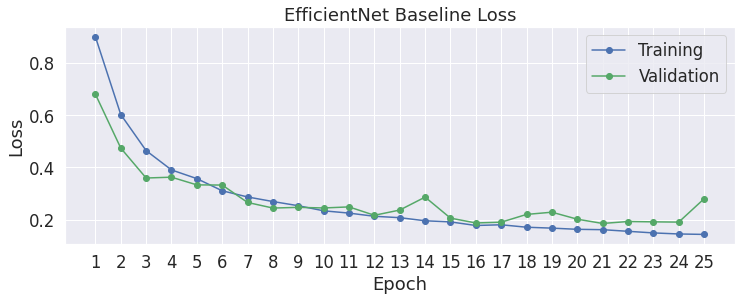

In [ ]:
plot_loss_graphs(train_loss_list,validation_loss_list, "EfficientNet Baseline Loss")

In [ ]:
model.load_state_dict(torch.load('model.pt', map_location = device))
trainer.test(model, test_dataloader)

  0%|          | 0/397 [00:00<?, ?it/s]

Test Accuracy: 93.80 %
Classification Report:
                      precision    recall  f1-score   support

               Covid       0.97      0.97      0.97       542
Other Lung Infection       0.92      0.90      0.91       902
              Normal       0.94      0.95      0.94      1529
     Viral Pneumonia       0.96      0.96      0.96       202

            accuracy                           0.94      3175
           macro avg       0.94      0.94      0.94      3175
        weighted avg       0.94      0.94      0.94      3175

F1 Score: 0.93787


## EfficientNet with attention mechanism

In [ ]:
epochs = 25
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 8
img_size = 224
n_classes = 4
version = "b0"
torch.manual_seed(35)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device Name: {}".format(device))

Device Name: cuda


In [ ]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (img_size,img_size)),
    transforms.Normalize([0.5094, 0.5094, 0.5094], [0.2355, 0.2355, 0.2355]),
    transforms.RandomHorizontalFlip(),
])

dataset = ImageFolder(root='Colab', transform=transformer)
print(dataset.class_to_idx)
dataloader = torch.utils.data.DataLoader(
  dataset, 
  # batch size is whole datset
  batch_size= batch_size, 
  shuffle=True, 
  num_workers=0)

{'Covid': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [ ]:
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.15, stratify=dataset.targets)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True)

In [ ]:
def accuracy(y_pred,y_true):
    y_pred = nn.functional.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
class Trainer():
    def __init__(self, criterion, optimizer, schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self, model, trainloader):
        
        train_acc = 0.0
        train_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            # nn.utils.clip_grad_value_(model.parameters(), 1)
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
            
        return train_acc/len(trainloader), train_loss/len(trainloader)

    
    def valid_batch_loop(self, model, validloader):
        
        valid_acc = 0.0
        valid_loss = 0.0
        
        for images, labels in tqdm(validloader):

            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            valid_acc += accuracy(logits, labels)
            valid_loss += loss.item()
        
        return valid_acc/len(validloader), valid_loss / len(validloader)

    def valid_batch_loop_test(self, model, validloader):

        total = 0
        correct = 0
        final_prediction = []
        final_labels = []

        for images, labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)

            y_pred = nn.functional.softmax(logits,dim = 1)
            _, predicted = torch.max(y_pred, dim=1)

            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            
            final_labels.append(labels.cpu().detach().numpy())
            final_prediction.append(predicted.cpu().detach().numpy())
        final_labels = np.concatenate(final_labels)
        final_prediction = np.concatenate(final_prediction)
        print("Test Accuracy: {:.2f} %".format((correct/total)*100))
        print("Classification Report:")
        print(classification_report(final_labels, final_prediction, target_names= ["Covid","Other Lung Infection","Normal","Viral Pneumonia"]))
        print("F1 Score: {:.5f}".format(f1_score(final_labels, final_prediction, average = "macro")))

    def test(self, model, validloader):

        model.eval()
        self.valid_batch_loop_test(model, validloader)


    def fit(self, model, trainloader, validloader, epochs):
        
        model = model.to(device)
        valid_min_loss = np.Inf
        train_loss_list = []
        validation_loss_list = []

        for i in range(epochs):
            
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            # self.schedular.step(avg_train_loss)
            train_loss_list.append([i+1, avg_train_loss])
            
            model.eval()
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            validation_loss_list.append([i+1, avg_valid_loss])

            if avg_valid_loss <= valid_min_loss:
                print("Valid loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), "model.pt")
                valid_min_loss = avg_valid_loss
                
            print("Epoch: {} Train Loss: {} Train Acc: {}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch: {} Valid Loss: {} Valid Acc: {}".format(i+1, avg_valid_loss, avg_valid_acc))
        return train_loss_list, validation_loss_list

In [ ]:
def plot_loss_graphs(training_loss_list,validation_loss_list, title):
  df_stats = pd.DataFrame(training_loss_list, columns = ['epoch','training_loss'])
  df_stats_val = pd.DataFrame(validation_loss_list, columns = ['epoch','validation_loss'])
  df_stats = pd.merge(df_stats, df_stats_val, on = 'epoch', how = 'inner')

  sns.set(style='darkgrid')
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,4)
  plt.plot(df_stats['epoch'],df_stats['training_loss'], 'b-o', label="Training")
  plt.plot(df_stats['epoch'],df_stats['validation_loss'], 'g-o', label="Validation")

  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([i for i in df_stats['epoch']])
  plt.show()

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_normal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [ ]:
class _GridAttentionBlockND(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(_GridAttentionBlockND, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_debug', 'concatenation_residual']

        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        self.mode = mode
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        self.W = nn.Sequential(
            conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        for m in self.children():
            init_weights(m, init_type='kaiming')

        if mode == 'concatenation':
            self.operation_function = self._concatenation
        elif mode == 'concatenation_debug':
            self.operation_function = self._concatenation_debug
        elif mode == 'concatenation_residual':
            self.operation_function = self._concatenation_residual
        else:
            raise NotImplementedError('Unknown operation function.')


    def forward(self, x, g):
        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)
        sigm_psi_f = F.sigmoid(self.psi(f))
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f

    def _concatenation_debug(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.softplus(theta_x + phi_g)
        sigm_psi_f = F.sigmoid(self.psi(f))
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


    def _concatenation_residual(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)
        f = self.psi(f).view(batch_size, 1, -1)
        sigm_psi_f = F.softmax(f, dim=2).view(batch_size, 1, *theta_x.size()[2:])
        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


class GridAttentionBlock2D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(GridAttentionBlock2D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=2, mode=mode,
                                                   sub_sample_factor=sub_sample_factor,
                                                   )

class _GridAttentionBlockND_TORR(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation_mean',
                 sub_sample_factor=(1,1,1), bn_layer=True, use_W=True, use_phi=True, use_theta=True, use_psi=True, nonlinearity1='relu'):
        super(_GridAttentionBlockND_TORR, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_softmax',
                        'concatenation_sigmoid', 'concatenation_mean',
                        'concatenation_range_normalise', 'concatenation_mean_flow']

        self.mode = mode
        self.dimension = dimension
        self.sub_sample_factor = sub_sample_factor if isinstance(sub_sample_factor, tuple) else tuple([sub_sample_factor])*dimension
        self.sub_sample_kernel_size = self.sub_sample_factor
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        self.W = lambda x: x
        self.theta = lambda x: x
        self.psi = lambda x: x
        self.phi = lambda x: x
        self.nl1 = lambda x: x

        if use_W:
            if bn_layer:
                self.W = nn.Sequential(
                    conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
                    bn(self.in_channels),
                )
            else:
                self.W = conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0)

        if use_theta:
            self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                                 kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)


        if use_phi:
            self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                               kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)


        if use_psi:
            self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)


        if nonlinearity1:
            if nonlinearity1 == 'relu':
                self.nl1 = lambda x: F.relu(x, inplace=True)

            elif nonlinearity1 == 'leakyrelu':
                self.nl1 = lambda x: F.leaky_relu(x, negative_slope = 0.01, inplace=True)

            elif nonlinearity1 == 'silu':
                self.nl1 = lambda x: F.silu(x)


        if 'concatenation' in mode:
            self.operation_function = self._concatenation
        else:
            raise NotImplementedError('Unknown operation function.')

        for m in self.children():
            init_weights(m, init_type='orthogonal')


        if use_psi and self.mode == 'concatenation_sigmoid':
            nn.init.constant(self.psi.bias.data, 3.0)

        if use_psi and self.mode == 'concatenation_softmax':
            nn.init.constant(self.psi.bias.data, 10.0)

        if use_psi and self.mode == 'concatenation_mean':
            nn.init.constant(self.psi.bias.data, 3.0)

        if use_psi and self.mode == 'concatenation_range_normalise':
            nn.init.constant(self.psi.bias.data, 3.0)

        parallel = False
        if parallel:
            if use_W: self.W = nn.DataParallel(self.W)
            if use_phi: self.phi = nn.DataParallel(self.phi)
            if use_psi: self.psi = nn.DataParallel(self.psi)
            if use_theta: self.theta = nn.DataParallel(self.theta)

    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''

        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()
        phi_g = F.upsample(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)

        f = theta_x + phi_g
        f = self.nl1(f)

        psi_f = self.psi(f)
        if self.mode == 'concatenation_softmax':
            sigm_psi_f = F.softmax(psi_f.view(batch_size, 1, -1), dim=2)
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
        elif self.mode == 'concatenation_mean':
            psi_f_flat = psi_f.view(batch_size, 1, -1)
            psi_f_sum = torch.sum(psi_f_flat, dim=2)#clamp(1e-6)
            psi_f_sum = psi_f_sum[:,:,None].expand_as(psi_f_flat)

            sigm_psi_f = psi_f_flat / psi_f_sum
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
        elif self.mode == 'concatenation_mean_flow':
            psi_f_flat = psi_f.view(batch_size, 1, -1)
            ss = psi_f_flat.shape
            psi_f_min = psi_f_flat.min(dim=2)[0].view(ss[0],ss[1],1)
            psi_f_flat = psi_f_flat - psi_f_min
            psi_f_sum = torch.sum(psi_f_flat, dim=2).view(ss[0],ss[1],1).expand_as(psi_f_flat)

            sigm_psi_f = psi_f_flat / psi_f_sum
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])
        elif self.mode == 'concatenation_range_normalise':
            psi_f_flat = psi_f.view(batch_size, 1, -1)
            ss = psi_f_flat.shape
            psi_f_max = torch.max(psi_f_flat, dim=2)[0].view(ss[0], ss[1], 1)
            psi_f_min = torch.min(psi_f_flat, dim=2)[0].view(ss[0], ss[1], 1)

            sigm_psi_f = (psi_f_flat - psi_f_min) / (psi_f_max - psi_f_min).expand_as(psi_f_flat)
            sigm_psi_f = sigm_psi_f.view(batch_size, 1, *theta_x_size[2:])

        elif self.mode == 'concatenation_sigmoid':
            sigm_psi_f = F.sigmoid(psi_f)
        else:
            raise NotImplementedError

        sigm_psi_f = F.upsample(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f


class GridAttentionBlock2D_TORR(_GridAttentionBlockND_TORR):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(1,1), bn_layer=True,
                 use_W=True, use_phi=True, use_theta=True, use_psi=True,
                 nonlinearity1='relu'):
        super(GridAttentionBlock2D_TORR, self).__init__(in_channels,
                                               inter_channels=inter_channels,
                                               gating_channels=gating_channels,
                                               dimension=2, mode=mode,
                                               sub_sample_factor=sub_sample_factor,
                                               bn_layer=bn_layer,
                                               use_W=use_W,
                                               use_phi=use_phi,
                                               use_theta=use_theta,
                                               use_psi=use_psi,
                                               nonlinearity1=nonlinearity1)

In [ ]:
phi_values = {
    "b0": (0, 224, 0.2),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            # nn.ReLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


In [ ]:
class EfficientNetAttention(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetAttention, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors("b0")
        last_channels = ceil(1280 * width_factor)
        self.initial_layer = CNNBlock(3, 32, 3, stride=2, padding=1)

        self.irb1 = InvertedResidualBlock( 32, 16 , expand_ratio=1, stride = 1, kernel_size= 3, padding= 1,)
        self.irb2 = InvertedResidualBlock( 16, 24 , expand_ratio=6, stride = 2, kernel_size= 3, padding= 1,)
        self.irb3 = InvertedResidualBlock( 24, 24 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
        self.irb4 = InvertedResidualBlock( 24, 40 , expand_ratio=6, stride = 2, kernel_size= 5, padding= 2,)
        self.irb5 = InvertedResidualBlock( 40, 40 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb6 = InvertedResidualBlock( 40, 80 , expand_ratio=6, stride = 2, kernel_size= 3, padding= 1,)
        self.irb7 = InvertedResidualBlock( 80, 80 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
        self.irb8 = InvertedResidualBlock( 80, 80 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
        self.irb9 = InvertedResidualBlock( 80, 112 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb10 = InvertedResidualBlock( 112, 112 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb11 = InvertedResidualBlock( 112, 112 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb12 = InvertedResidualBlock( 112, 192 , expand_ratio=6, stride = 2, kernel_size= 5, padding= 2,)
        self.irb13 = InvertedResidualBlock( 192, 192 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb14 = InvertedResidualBlock( 192, 192 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb15 = InvertedResidualBlock( 192, 192 , expand_ratio=6, stride = 1, kernel_size= 5, padding= 2,)
        self.irb16 = InvertedResidualBlock( 192, 320 , expand_ratio=6, stride = 1, kernel_size= 3, padding= 1,)
   
        self.final_layer = CNNBlock(320, last_channels, kernel_size=1, stride=1, padding=0)
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.compatibility_score1 = GridAttentionBlock2D_TORR(in_channels=192, gating_channels=1280,
                                                     inter_channels=1280, sub_sample_factor=(3,3),
                                                     mode='concatenation_mean_flow', use_W=True, use_phi=True,
                                                     use_theta=True, use_psi=True, nonlinearity1='leakyrelu')

        self.compatibility_score2 = GridAttentionBlock2D_TORR(in_channels=320, gating_channels=1280,
                                                     inter_channels=1280, sub_sample_factor=(3,3),
                                                     mode='concatenation_mean_flow', use_W=True, use_phi=True,
                                                     use_theta=True, use_psi=True, nonlinearity1='leakyrelu')
        
        self.classifier = nn.Linear(192 + 320 + 1280, num_classes)
        self.aggregate = self.aggregation_concat

    def aggregation_concat(self, *attended_maps):
        return self.classifier(torch.cat(attended_maps, dim=1))


    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.irb1(x)
        x = self.irb2(x)
        x = self.irb3(x)
        x = self.irb4(x)
        x = self.irb5(x)
        x = self.irb6(x)
        x = self.irb7(x)
        x = self.irb8(x)
        x = self.irb9(x)
        x = self.irb10(x)
        x = self.irb11(x)
        x = self.irb12(x)
        x = self.irb13(x)
        x = self.irb14(x)
        antepenultimate_value = self.irb15(x)
        penultimate_value = self.irb16(antepenultimate_value)
        final_value = self.final_layer(penultimate_value)
        pooled_value = self.pool(final_value)
        pooled_value = pooled_value.view(pooled_value.shape[0],pooled_value.shape[1])
        g_conv1, att1 = self.compatibility_score1(antepenultimate_value, final_value)
        g_conv2, att2 = self.compatibility_score2(penultimate_value, final_value)
        g1 = torch.sum(g_conv1.view(g_conv1.shape[0],g_conv1.shape[1],-1), dim=-1)
        g2 = torch.sum(g_conv2.view(g_conv2.shape[0],g_conv2.shape[1],-1), dim=-1)
        x = self.aggregate(g1, g2, pooled_value)
        return x

In [ ]:
model = EfficientNetAttention(4)
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
schedular = None

trainer = Trainer(criterion, optimizer, schedular)
train_loss_list, validation_loss_list = trainer.fit(model, train_dataloader, test_dataloader, epochs = epochs)

In [ ]:
summary(model, (3,224,224))

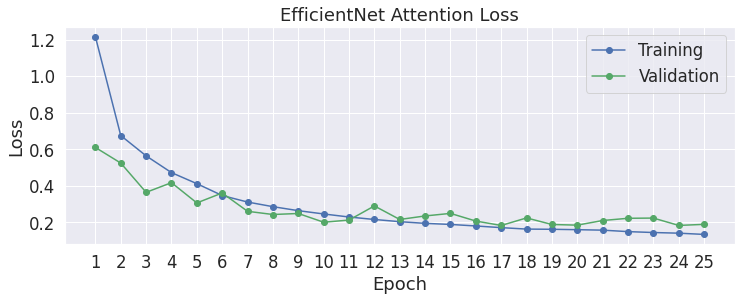

In [ ]:
plot_loss_graphs(train_loss_list,validation_loss_list, "EfficientNet Attention Loss")

In [ ]:
model.load_state_dict(torch.load('model.pt', map_location = device))
trainer.test(model, test_dataloader)

  0%|          | 0/397 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Test Accuracy: 94.08 %
Classification Report:
                      precision    recall  f1-score   support

               Covid       0.97      0.98      0.97       542
Other Lung Infection       0.93      0.89      0.91       902
              Normal       0.93      0.95      0.94      1529
     Viral Pneumonia       0.98      0.97      0.97       202

            accuracy                           0.94      3175
           macro avg       0.95      0.95      0.95      3175
        weighted avg       0.94      0.94      0.94      3175

F1 Score: 0.94946
